In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import random
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_columns', None)

seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import ktrain
from ktrain import tabular

# Classification and Regression on Tabular Data in `ktrain`

As of v0.19.x, *ktrain* supports classification and regression on "traditional" tabular datasets. We will cover two examples in this notebook:
- **Part I: Classification**:  predicting which [Titanic passengers survived](https://www.kaggle.com/c/titanic)
- **Part II: Regression**:  predicting the age of people from [census data](http://archive.ics.uci.edu/ml/datasets/Census+Income)

Let's begin with a demonstration of tabular classfication using the well-studied Titatnic dataset from Kaggle.

## Part I:  Classification for Tabular Data



### Solving the Titanic Kaggle Challenge in `ktrain`

This notebook demonstrates using *ktrain* for predicting which passengers survived the Titatnic shipwreck.

The dataset can be [downloaded from Kaggle here](https://www.kaggle.com/c/titanic/overview). There is a `train.csv` with labels (i.e., `Survived`) and a `test.csv` with no labels.  We will only use `train.csv` in this notebook.

Let's begin by loading the data as a pandas DataFrame and inspecting it.

In [3]:
train_df = pd.read_csv('data/titanic/train.csv', index_col=0)

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We'll drop the `Name`, `Ticket`, `Cabin` columns, as they seem like they'll be less predictive.  These columns are largely unique or near-unique to passengers.

In [5]:
train_df = train_df.drop('Name', 1)
train_df = train_df.drop('Ticket', 1)
train_df = train_df.drop('Cabin', 1)

*ktrain* will automatically split out a validation set if given only a training set.  But, let's also manually split out a test set that we can evaluate later.

In [6]:
np.random.seed(42)
p = 0.1 # 10% for test set
prop = 1-p
df = train_df.copy()
msk = np.random.rand(len(df)) < prop
train_df = df[msk]
test_df = df[~msk]

In [7]:
train_df.shape

(799, 8)

In [8]:
test_df.shape

(92, 8)

### STEP 1: Load and Preprocess the Data

In [9]:
trn, val, preproc = tabular.tabular_from_df(train_df, label_columns=['Survived'], random_state=42)

processing train: 717 rows x 8 columns

The following integer column(s) are being treated as categorical variables:
['Pclass', 'SibSp', 'Parch']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 82 rows x 8 columns


##### Automated Preprocessing
*ktrain* automatically preprocesses the dataset appropriately.  Numerical columns are automatically normalized, missing values are handled, and categorical variables will be vectorized as [entity embeddings](https://arxiv.org/abs/1604.06737) for input to a neural network. 

##### Auto-generated Features
*ktrain* will auto-generate some new features.  For instance, if `Age` is missing for a particular individual, an `Age_na=True` feature will be automatically added.

New date features are also automatically added.  This dataset does not have any **date** fields.  If it did, we could populate the `date_columns` parameter to `tabular_from_df` in which case they would be used to auto-generate new features (e.g., `Day`, `Week`, `Is_month_start`, `Is_quarter_end`, etc.) using methods adapted from the **fastai** library.

##### Manually-Engineered Features

In addition to these auto-generated features, one can also optionally add manually-generated, dataset-specific features to `train_df` **prior** to invoking `tabular_from_df`. For instance, the `Cabin` feature we discared earlier might be used to extract the **deck** associated with each passenger (e.g., **B22** --> **Deck B**).

### STEP 2: Create a Model and Wrap in `Learner`

*ktrain* uses multilayer perceptrons as the model for tabular datasets. The model can be configured with arguments to `tabular_classifier` (e.g., number and size of hidden layers, dropout values, etc.), but we will leave the defaults here.

In [10]:
tabular.print_tabular_classifiers()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [11]:
model = tabular.tabular_classifier('mlp', trn)

Is Multi-Label? False
done.


In [12]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

### STEP 3: Estimate the Learning Rate

Based on the plot below, we will choose a learning rate of `1e-3`.

simulating training for different learning rates... this may take a few moments...
Train for 22 steps
Epoch 1/5
22/22 [==============================] - 1s 50ms/step - loss: 0.6882 - accuracy: 0.5985
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.6819 - accuracy: 0.6263
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.6495 - accuracy: 0.6584
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 2.1039 - accuracy: 0.6569
Epoch 5/5
 3/22 [===>..........................] - ETA: 0s - loss: 25.0747 - accuracy: 0.5455

done.
Visually inspect loss plot and select learning rate associated with falling loss


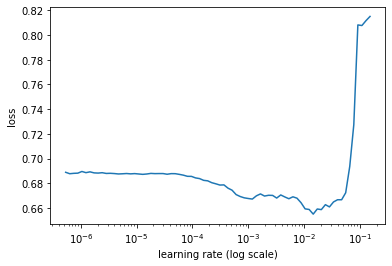

In [13]:
learner.lr_find(show_plot=True, max_epochs=5)

### STEP 4: Train the Model

In [14]:
learner.fit_onecycle(5e-3, 10)



begin training using onecycle policy with max lr of 0.005...
Train for 23 steps, validate for 3 steps
Epoch 1/10
23/23 [==============================] - 1s 58ms/step - loss: 0.6388 - accuracy: 0.6597 - val_loss: 0.5437 - val_accuracy: 0.7561
Epoch 2/10
23/23 [==============================] - 1s 23ms/step - loss: 0.5855 - accuracy: 0.6876 - val_loss: 0.4851 - val_accuracy: 0.7805
Epoch 3/10
23/23 [==============================] - 0s 22ms/step - loss: 0.5259 - accuracy: 0.7448 - val_loss: 0.4044 - val_accuracy: 0.8659
Epoch 4/10
23/23 [==============================] - 1s 23ms/step - loss: 0.4985 - accuracy: 0.7713 - val_loss: 0.3639 - val_accuracy: 0.8902
Epoch 5/10
23/23 [==============================] - 1s 22ms/step - loss: 0.4762 - accuracy: 0.7894 - val_loss: 0.3364 - val_accuracy: 0.8659
Epoch 6/10
23/23 [==============================] - 1s 23ms/step - loss: 0.4626 - accuracy: 0.7908 - val_loss: 0.3174 - val_accuracy: 0.9146
Epoch 7/10
23/23 [==============================] 

Since we don't appear to be quite overfitting yet, we could try to train further.  But, we will stop here.


**Let's evaluate the validation set:**

In [15]:
learner.evaluate(val, class_names=preproc.get_classes())

              precision    recall  f1-score   support

not_Survived       0.89      0.96      0.92        49
    Survived       0.93      0.82      0.87        33

    accuracy                           0.90        82
   macro avg       0.91      0.89      0.90        82
weighted avg       0.90      0.90      0.90        82



array([[47,  2],
       [ 6, 27]])

### Make Predictions

The `Predictor` for tabular datasets accepts input as a dataframe in the same format as the original training dataframe. 

We will use `test_df` that we created earlier.

In [16]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [17]:
preds = predictor.predict(test_df, return_proba=True)

In [18]:
preds.shape

(92, 2)

In [19]:
print('test accuracy:')
(np.argmax(preds, axis=1) == test_df['Survived'].values).sum()/test_df.shape[0]

test accuracy:


0.8478260869565217

**Our final results as a DataFrame:**

In [20]:
df = test_df.copy()[[c for c in test_df.columns.values if c != 'Survived']]
df['Survived'] = test_df['Survived']
df['predicted_Survived'] = np.argmax(preds, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,predicted_Survived
PassengerId,,,,,,,,,
2,1,female,38.0,1,0,71.2833,C,1,1
12,1,female,58.0,0,0,26.5500,S,1,1
34,2,male,66.0,0,0,10.5000,S,0,0
35,1,male,28.0,1,0,82.1708,C,0,0
44,2,female,3.0,1,2,41.5792,C,1,1


### Explaining Predictions

We can use the `explain` method to better understand **why** a prediction was made for a particular example.  In the cell above, we see that our model predicted **Survived** for the fourth row ( `PassengerID=35`), but the true label is **Not Survived**.

Let's better understand why.

The `explain` method accepts at minimum the following three inputs:
1. **df**: a pandas DataFrame in the same format is the original training DataFrame
2. **row_index**: the DataFrame index of the example (here, we choose PassengerID=35)
3. **class_id**: the id of the class of interest (we choose the **Survived** class in this case)

One can also replace the `row_index=35` with `row_num=3`, as both denote the fourth row.

Explanation for class = Survived (PassengerId=35): 


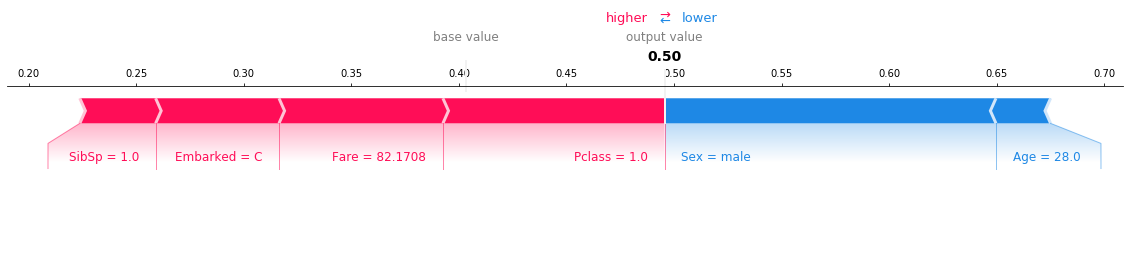

In [21]:
predictor.explain(test_df, row_index=35, class_id=1)

The plot above is generated using the [shap](https://github.com/slundberg/shap) library.  The features in red are causing our model to increase the prediction for the **Survived** class, while features in blue cause our model to *decrease* the prediction for **Survived** (or *increase* the prediction for **Not_Survived**).  

From the plot, we see that the predicted softmax probability for `Survived` is **50%**, which is a comparatively much less confident classification than other classifications. Why is this?

We see that`Sex=male` is an influential feature that is pushing the prediction lower towards **Not_Survived**, as it was women and children given priority when allocating lifeboats on the Titanic. 

On the other hand, we also see that this is a First Class passenger (`Pclass=1`) with a higher-than-average `Fare` price of *82.17*.  In the cell below, you'll see that the average `Fare` price is only *32*.  (Moreover, this passenger embarked from Cherbourg, which has been shown to be correlated with survival.)  Such features suggest that this is an upper-class, wealthier passenger and, therefore, more likely to make it onto a lifeboat and survive. We know from history that  crew members were ordered to close gates that lead to the upper decks so the first and second class passengers could be evacuated first. As a result, these "upper class" features are pushing our model to increase the classification to **Survived**.   

**Thus, there are two opposing forces at play working against each other in this prediction,** which explains why the prediction probability is comparatively nearer to the border than other examples.



In [22]:
train_df['Fare'].mean()

32.23080325406759

**NOTE**: We choose `class_id=1` in the example above because the **Survived** class of interest has an index position of 1 in the `class_names` list:

In [23]:
preproc.get_classes()

['not_Survived', 'Survived']

Let us now look at the examples for which we were the most wrong (highest loss).

In [24]:
learner.view_top_losses(val_data=preproc.preprocess_test(test_df), preproc=preproc, n=3)

processing test: 92 rows x 8 columns
----------
id:27 | loss:3.31 | true:Survived | pred:not_Survived)

----------
id:53 | loss:2.84 | true:not_Survived | pred:Survived)

----------
id:19 | loss:2.52 | true:Survived | pred:not_Survived)



The example with the highest losses are `row_num={27, 53, 19}`. Why did we get these so wrong?  Let's examine `row_num=53`.  Note that these IDs shown in the `view_top_losses` output are the raw row numbers, not DataFrame indices (or PassengerIDs). So, we need to use `row_num`, not `row_index` here.


Explanation for class = Survived (row_num=53): 


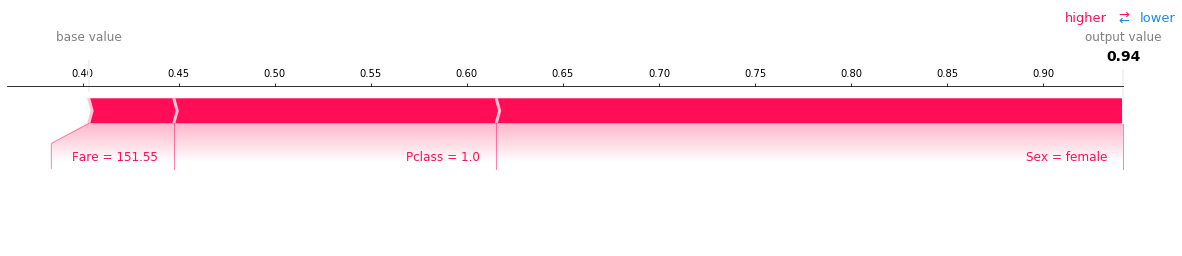

In [25]:
predictor.explain(test_df, row_num=53, class_id=1)

This is a wealthy First Class (`Pclass=1`) female passenger with a very high `Fare` price of 151.55. As mentioned above, such a passenger had a high chance for survival, which explains our model's high prediction for **Survival**. Yet, she did not survive. Upon further investigation, we can understand why.  This particular passenger is **Bess Allison**, a wealthy married 25-year old mother to two toddlers.  When the collision occurred, her and her husband could not locate their nanny (Alice Cleaver) and son (Trevor).  So, Bess, her husband, and her 3-year-old daughter Loraine stayed behind to wait for them instead of evacuating with other First and Second Class passengers with children.  They were last seen standing together smiling on the promenage deck.  All three died with her daughter Loraine being the only child in 1st class and 2nd class who died on the Titanic.  Their son and nanny successfully evacuated and survived.

REFERENCE: [https://rt.cto.mil/stpe/](https://rt.cto.mil/stpe/)

### Saving and Reloading the Tabular Predictor

It is easy to save and reload the predictor for deployment scenarios.

In [26]:
predictor.save('/tmp/titanic_predictor')

In [27]:
reloaded_predictor = ktrain.load_predictor('/tmp/titanic_predictor/')

In [28]:
reloaded_predictor.predict(test_df)[:5]

['Survived', 'Survived', 'not_Survived', 'not_Survived', 'Survived']

### Evaluating Test Sets Automatically

When we evaulated the test set above, we did so manually.  To evaluate a test set automatically,
one can invoke the `learner.evaluate` method and supply a preprocessed test set as an argument:

In [29]:
learner.evaluate(preproc.preprocess_test(test_df), class_names=preproc.get_classes())

processing test: 92 rows x 8 columns
              precision    recall  f1-score   support

not_Survived       0.85      0.91      0.88        57
    Survived       0.84      0.74      0.79        35

    accuracy                           0.85        92
   macro avg       0.85      0.83      0.83        92
weighted avg       0.85      0.85      0.85        92



array([[52,  5],
       [ 9, 26]])

The `learner.evaluate` method is simply an alias to `learner.validate`, which can also accept a dataset as an argument.  If no argument is supplied, metrics will be computed for `learner.val_data`, which was supplied to `get_learner` above.

## Part II:  Regression for Tabular Data

We will briefly demonstrate tabular regression in *ktrain* by simply predicting the `age` attribute in the Census dataset available from te UCI Machine Learning repository.  This is the same example used in the [AutoGluon regression example](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-quickstart.html#regression-predicting-numeric-table-columns). Let's begin by downloading the dataset from the AutoGluon website.

In [30]:
import urllib.request
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv', 
                           '/tmp/train.csv')
!ls /tmp/train.csv

/tmp/train.csv


### STEP 1: Load and Preprocess Data

Make sure you specify `is_regression=True` here as we are predicting a numerical dependent variable (i.e., `age`).

In [31]:
trn, val, preproc = tabular.tabular_from_csv('/tmp/train.csv', label_columns='age', 
                                             is_regression=True, random_state=42)

processing train: 35179 rows x 15 columns

The following integer column(s) are being treated as categorical variables:
['education-num']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 3894 rows x 15 columns


Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.


We used `tabular_from_csv` to load the dataset, but let's also quickly load as DataFrame to see it:

In [2]:
pd.read_csv('/tmp/train.csv').head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,178478,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K
1,23,State-gov,61743,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,35,United-States,<=50K
2,46,Private,376789,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K
3,55,?,200235,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,50,United-States,>50K
4,36,Private,224541,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,El-Salvador,<=50K


### STEP 2: Create a Model and Wrap in `Learner`

We'll use `tabular_regression_model` to create a regression model.

In [33]:
tabular.print_tabular_regression_models()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [34]:
model = tabular.tabular_regression_model('mlp', trn)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

done.


### STEP 3: Estimate Learning Rate

simulating training for different learning rates... this may take a few moments...
Train for 274 steps
Epoch 1/1024
274/274 [==============================] - 8s 29ms/step - loss: 1681.9281 - mae: 38.6405
Epoch 2/1024
274/274 [==============================] - 7s 25ms/step - loss: 1650.8196 - mae: 38.2378
Epoch 3/1024
274/274 [==============================] - 7s 26ms/step - loss: 677.0598 - mae: 20.7480
Epoch 4/1024
274/274 [==============================] - 7s 26ms/step - loss: 123.2551 - mae: 8.7116
Epoch 5/1024
274/274 [==============================] - 7s 26ms/step - loss: 229.2279 - mae: 11.2846
Epoch 6/1024
 67/274 [======>.......................] - ETA: 6s - loss: 384.0570 - mae: 12.9530

done.
Visually inspect loss plot and select learning rate associated with falling loss


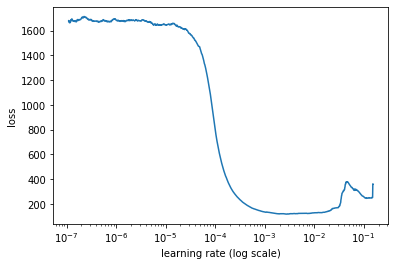

In [35]:
learner.lr_find(show_plot=True)

### STEP 4: Train the Model

According to our final validation MAE (see below), our age predictions are only off about **~7 years**.

In [36]:
learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train for 275 steps, validate for 122 steps
Epoch 1/1024
275/275 [==============================] - 11s 39ms/step - loss: 411.0144 - mae: 14.8399 - val_loss: 108.4525 - val_mae: 8.2879
Epoch 2/1024
275/275 [==============================] - 10s 35ms/step - loss: 116.3624 - mae: 8.4576 - val_loss: 102.6719 - val_mae: 8.0353
Epoch 3/1024
275/275 [==============================] - 10s 35ms/step - loss: 112.9161 - mae: 8.3066 - val_loss: 100.8348 - val_mae: 7.9844
Epoch 4/1024
275/275 [==============================] - 10s 35ms/step - loss: 111.2987 - mae: 8.2026 - val_loss: 97.9699 - val_mae: 7.7425
Epoch 5/1024
275/275 [==============================] - 10s 35ms/step - loss: 109.3430 - mae: 8.1120 - val_loss: 95.7590 - val_mae: 7.6947
Epoch 6/1024
275/275 [==============================] - 10s 35ms/step - l

In [37]:
learner.validate()

[('mae', 7.398410168683522)]

See the [House Price Prediction notebook](https://github.com/amaiya/ktrain/blob/master/examples/tabular/HousePricePrediction-MLP.ipynb) for another regression example.